In [242]:
%%capture
!pip install torch numpy pandas matplotlib scikit-learn

!pip install git+https://github.com/gretelai/gretel-synthetics.git

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import matplotlib.dates as md

import torch

from gretel_synthetics.timeseries_dgan.dgan import DGAN
from gretel_synthetics.timeseries_dgan.config import DGANConfig, OutputType



In [2]:
# Read smart home sensor data from https://archive.ics.uci.edu/ml/datasets/Appliances+energy+prediction
sensor_df = pd.read_csv("https://archive.ics.uci.edu/ml/machine-learning-databases/00374/energydata_complete.csv")
sensor_df["datetime"] = pd.to_datetime(sensor_df["date"])
sensor_df

,date,Appliances,lights,T1,RH_1,T2,RH_2,T3,RH_3,T4,...,RH_9,T_out,Press_mm_hg,RH_out,Windspeed,Visibility,Tdewpoint,rv1,rv2,datetime
0,2016-01-11 17:00:00,60,30,19.890000,47.596667,19.200000,44.790000,19.790000,44.730000,19.000000,...,45.5300,6.600000,733.5,92.000000,7.000000,63.000000,5.300000,13.275433,13.275433,2016-01-11 17:00:00
1,2016-01-11 17:10:00,60,30,19.890000,46.693333,19.200000,44.722500,19.790000,44.790000,19.000000,...,45.5600,6.483333,733.6,92.000000,6.666667,59.166667,5.200000,18.606195,18.606195,2016-01-11 17:10:00
2,2016-01-11 17:20:00,50,30,19.890000,46.300000,19.200000,44.626667,19.790000,44.933333,18.926667,...,45.5000,6.366667,733.7,92.000000,6.333333,55.333333,5.100000,28.642668,28.642668,2016-01-11 17:20:00
3,2016-01-11 17:30:00,50,40,19.890000,46.066667,19.200000,44.590000,19.790000,45.000000,18.890000,...,45.4000,6.250000,733.8,92.000000,6.000000,51.500000,5.000000,45.410389,45.410389,2016-01-11 17:30:00
4,2016-01-11 17:40:00,60,40,19.890000,46.333333,19.200000,44.530000,19.790000,45.000000,18.890000,...,45.4000,6.133333,733.9,92.000000,5.666667,47.666667,4.900000,10.084097,10.084097,2016-01-11 17:40:00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19730,2016-05-27 17:20:00,100,0,25.566667,46.560000,25.890000,42.025714,27.200000,41.163333,24.700000,...,46.7900,22.733333,755.2,55.666667,3.333333,23.666667,13.333333,43.096812,43.096812,2016-05-27 17:20:00
19731,2016-05-27 17:30:00,90,0,25.500000,46.500000,25.754000,42.080000,27.133333,41.223333,24.700000,...,46.7900,22.600000,755.2,56.000000,3.500000,24.500000,13.300000,49.282940,49.282940,2016-05-27 17:30:00
19732,2016-05-27 17:40:00,270,10,25.500000,46.596667,25.628571,42.768571,27.050000,41.690000,24.700000,...,46.7900,22.466667,755.2,56.333333,3.666667,25.333333,13.266667,29.199117,29.199117,2016-05-27 17:40:00
19733,2016-05-27 17:50:00,420,10,25.500000,46.990000,25.414000,43.036000,26.890000,41.290000,24.700000,...,46.8175,22.333333,755.2,56.666667,3.833333,26.166667,13.233333,6.322784,6.322784,2016-05-27 17:50:00


In [3]:
# Use 4 temperature columns for this example
COLUMNS = ["T1", "T2", "T3", "T_out"]

train_df = sensor_df[["datetime"] + COLUMNS]
train_df

,datetime,T1,T2,T3,T_out
0,2016-01-11 17:00:00,19.890000,19.200000,19.790000,6.600000
1,2016-01-11 17:10:00,19.890000,19.200000,19.790000,6.483333
2,2016-01-11 17:20:00,19.890000,19.200000,19.790000,6.366667
3,2016-01-11 17:30:00,19.890000,19.200000,19.790000,6.250000
4,2016-01-11 17:40:00,19.890000,19.200000,19.790000,6.133333
...,...,...,...,...,...
19730,2016-05-27 17:20:00,25.566667,25.890000,27.200000,22.733333
19731,2016-05-27 17:30:00,25.500000,25.754000,27.133333,22.600000
19732,2016-05-27 17:40:00,25.500000,25.628571,27.050000,22.466667
19733,2016-05-27 17:50:00,25.500000,25.414000,26.890000,22.333333


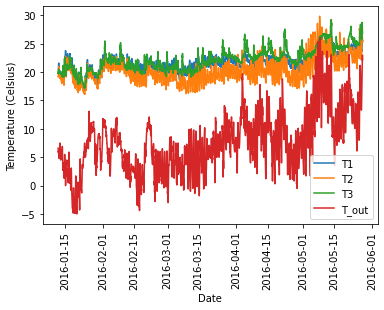

In [4]:
# Plot the 4 columns over the 4+ months of data
for c in COLUMNS:
    plt.plot(train_df["datetime"], train_df[c], label=c)
plt.xticks(rotation=90)
plt.legend()
plt.ylabel("Temperature (Celsius)")
plt.xlabel("Date")
plt.show()

In [5]:
# DGAN needs many example time series to train. Split into 1-day slices to
# create multiple examples.
features = train_df.drop(columns="datetime").to_numpy()
# Obsevations every 10 minutes, so 144 * 10 minutes = 1 day
n = features.shape[0] // 144
features = features[:(n*144),:].reshape(-1, 144, features.shape[1])
# Shape is now (# examples, # time points, # features)
print(features.shape)

(137, 144, 4)


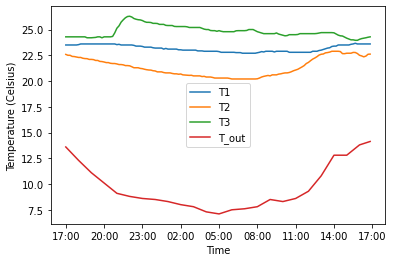

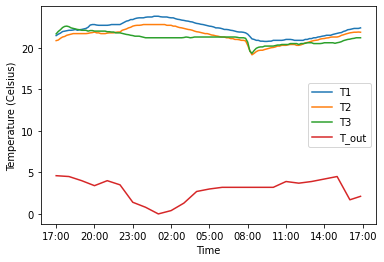

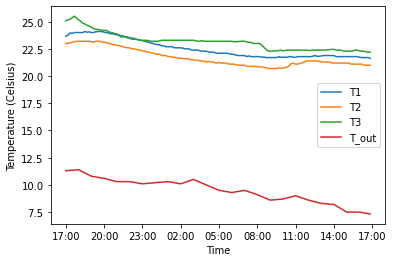

In [6]:
# Show a few of the 1-day training samples
xaxis_1day = train_df["datetime"][0:144]

def plot_day(f):
    for i, c in enumerate(COLUMNS):
        plt.plot(xaxis_1day, f[:,i], label=c)
    ax = plt.gca()
    ax.xaxis.set_major_locator(md.HourLocator(byhour=range(2,24,3)))
    ax.xaxis.set_major_formatter(md.DateFormatter("%H:%M"))
    plt.legend()
    plt.xlabel("Time")
    plt.ylabel("Temperature (Celsius)")
    plt.show()

plot_day(features[125,:,:])
plot_day(features[3,:,:])
plot_day(features[21,:,:])

In [7]:
# Recommended to train with a GPU
torch.cuda.is_available()

True

In [ ]:
%%capture

# Train DGAN model
model = DGAN(DGANConfig(
    max_sequence_len=features.shape[1],
    sample_len=12,
    batch_size=min(1000, features.shape[0]),
    apply_feature_scaling=True,
    apply_example_scaling=False,
    use_attribute_discriminator=False,
    generator_learning_rate=1e-4,
    discriminator_learning_rate=1e-4,
    epochs=10000,
))

model.train_numpy(
    features,
    feature_types=[OutputType.CONTINUOUS] * features.shape[2],
)

# Generate synthetic data
_, synthetic_features = model.generate_numpy(1000)



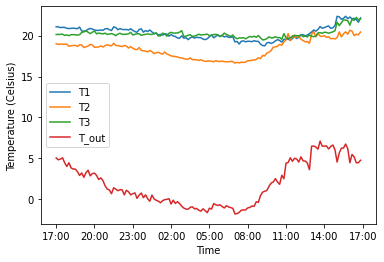

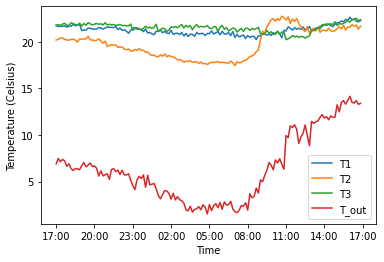

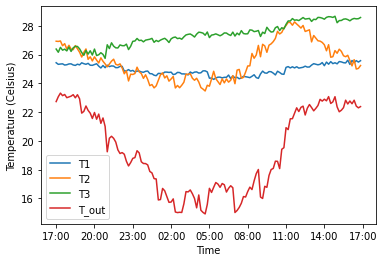

In [9]:
# Show some synthetic 1-day samples
plot_day(synthetic_features[825,:,:])
plot_day(synthetic_features[42,:,:])
plot_day(synthetic_features[496,:,:])

# Overall trends are similar to training samples, but with more local noise

In [10]:
# Compare (non-temporal) correlations between the 4 temperatures
synthetic_df = pd.DataFrame(synthetic_features.reshape(-1, synthetic_features.shape[2]), columns=train_df.columns[1:])

print("Correlation in real data:")
print(train_df.corr())
print()
print("Correlation in synthetic data:")
print(synthetic_df.corr())

# Correlations between temperature variables are similar

Correlation in real data:
             T1        T2        T3     T_out
T1     1.000000  0.836834  0.892402  0.682846
T2     0.836834  1.000000  0.735245  0.792255
T3     0.892402  0.735245  1.000000  0.699417
T_out  0.682846  0.792255  0.699417  1.000000

Correlation in synthetic data:
             T1        T2        T3     T_out
T1     1.000000  0.839000  0.880091  0.673575
T2     0.839000  1.000000  0.748595  0.779212
T3     0.880091  0.748595  1.000000  0.716991
T_out  0.673575  0.779212  0.716991  1.000000


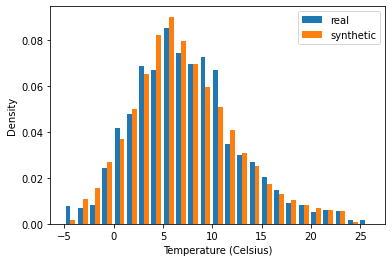

In [11]:
# Compare distribution of T_out values
plt.hist([features[:,:,3].flatten(), synthetic_features[:,:,3].flatten()], 
         label=["real", "synthetic"],
         bins=25,
         density=True)
plt.legend()
plt.xlabel("Temperature (Celsius)")
plt.ylabel("Density")
plt.show()

# Temperature distribution for T_out is similar

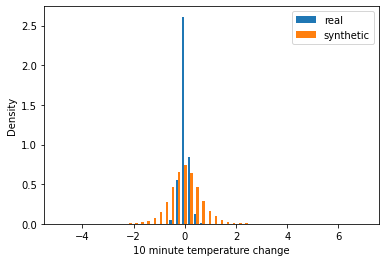

In [12]:
# Compare distribution of 1-step (10 minute) diffs for T_out
real_diffs = np.diff(features, axis=1)
synthetic_diffs = np.diff(synthetic_features, axis=1)

plt.hist([real_diffs[:,:,3].flatten(), synthetic_diffs[:,:,3].flatten()],
         label=["real", "synthetic"],
         bins=50,
         density=True)
plt.legend()
plt.xlabel("10 minute temperature change")
plt.ylabel("Density")
plt.show()

# 1-step diffs for synthetic data have higher variance, this aligns with the
# increased noise visible in the plots